In [1]:
import register, world
from register import dataset
import utils
import torch

Recmodel = register.MODELS[world.model_name](world.config, dataset)
Recmodel = Recmodel.to(world.device)

/home/baron/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Cpp extension not loaded
loading [../data/movielens]
9430 interactions for augmentation
80000 interactions for training
20000 interactions for testing
movielens Sparsity : 0.06304669364224533
movielens is ready to go
===========config================
{'A_n_fold': 100,
 'A_split': False,
 'batch_size': 4096,
 'bigdata': False,
 'bpr_batch_size': 4096,
 'decay': 0.0001,
 'dropout': 0,
 'keep_prob': 0.6,
 'latent_dim_rec': 64,
 'lightGCN_n_layers': 3,
 'lr': 0.001,
 'multicore': 0,
 'pretrain': 0,
 'test_u_batch_size': 92}
cores for test: 8
comment: lgn
tensorboard: 0
LOAD: 0
Weight path: ./checkpoints
Test Topks: [20]
using bpr loss
===========end===================
use NORMAL distribution initilizer
loading adjacency matrix
successfully loaded...
don't split the matrix
lgn is already to go(dropout:0)


## load modelallPos

In [2]:
weight_file = utils.getFileName()
Recmodel.load_state_dict(torch.load(weight_file,map_location=torch.device('cpu')))
world.cprint(f"loaded model weights from {weight_file}")

loaded model weights from /home/baron/HW/gnn_recsy/lightgcn/code/checkpoints/lgn-movielens-3-64-SimUser_all_3-aug_all_10.pth.tar


In [3]:
import Procedure
_ = Procedure.Test(dataset, Recmodel, 0,  world.config['multicore'])

{'precision': array([0.24568501]), 'recall': array([0.32993227]), 'ndcg': array([0.38048454])}


## 1. Vistualize weak user-item pair

max count: 643
min count: 5


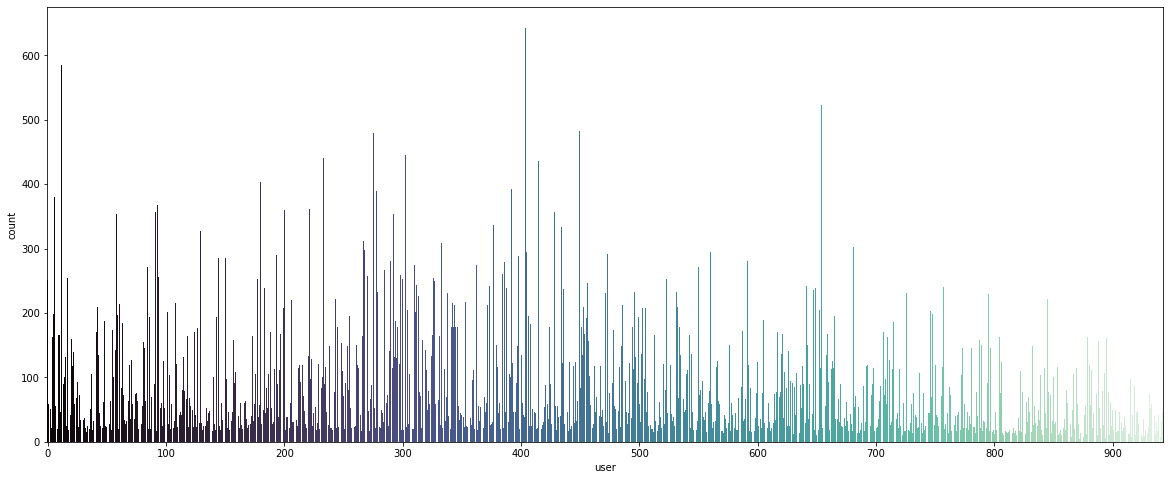

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

train_count = dict() 
for i in range(len(dataset.allPos)):
    train_count[i] = len(dataset.allPos[i])

print('max count: {}'.format(max(list(train_count.values()))))
print('min count: {}'.format(min(list(train_count.values()))))
df = pd.DataFrame({'user':range(len(train_count)), 'count':list(train_count.values())})
plt.figure(figsize=(20,8))
ax = sns.barplot(x="user", y="count", data=df, palette='mako')
step_xticks = range(0, len(train_count), 100)
_, ax = plt.xticks(step_xticks, step_xticks)

0.25    25.0
0.50    51.0
Name: count, dtype: float64


<AxesSubplot:xlabel='count'>

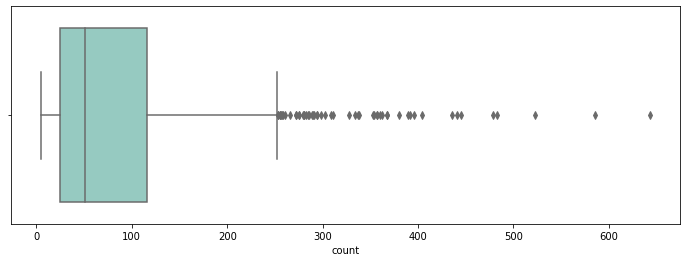

In [5]:
print(df['count'].quantile([.25, .5]))
plt.figure(figsize=(12,4))
sns.boxplot(df['count'], palette="Set3")

### user outlier

In [11]:
from matplotlib.cbook import boxplot_stats
outliers = [y for stat in boxplot_stats(df['count']) for y in stat['fliers']]
print("outlier start: {}".format(min(outliers)))
print("outlier ratio: {}".format(len(outliers)/len(df)))

outlier start: 253
outlier ratio: 0.05620360551431601


### hot Item

In [16]:
item_count = dict()
for i in range(len(dataset.allPos)):
    pos_items = dataset.allPos[i]
    for j in pos_items:
        if item_count.get(j):
            item_count[j] += 1
        else:
            item_count[j] = 1
print("total item: {}".format(len(item_count.keys())))
print('max count: {}'.format(max(list(item_count.values()))))
print('min count: {}'.format(min(list(item_count.values()))))

total item: 1650
max count: 475
min count: 1


0.50    23.00
0.75    65.75
Name: count, dtype: float64


<AxesSubplot:xlabel='count'>

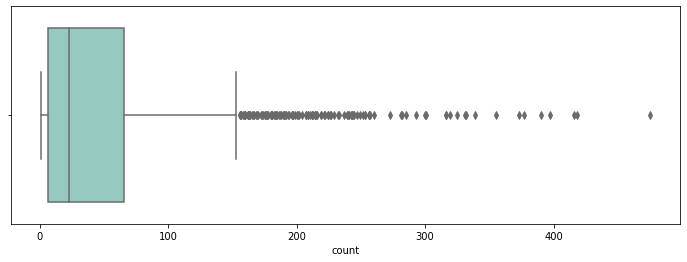

In [18]:
item_df = pd.DataFrame({'item': item_count.keys(), 'count':list(item_count.values())})
print(item_df['count'].quantile([.5, .75]))
plt.figure(figsize=(12,4))
sns.boxplot(item_df['count'], palette="Set3")

In [29]:
testDict:dict= dataset.testDict
users = list(testDict.keys())
allPos = dataset.getUserPosItems(users)
groundTrue = [testDict[u] for u in users]
batch_users_gpu = torch.Tensor(users).long()
batch_users_gpu = batch_users_gpu.to(world.device)
rating = Recmodel.getUsersRating(batch_users_gpu)

exclude_index = []
exclude_items = []
for range_i, items in enumerate(allPos):
    exclude_index.extend([range_i] * len(items))
    exclude_items.extend(items)
rating[exclude_index, exclude_items] = -(1<<10)

_, rating_K = torch.topk(rating, k=20)
del rating
rating_K.cpu()
rating_K.shape

torch.Size([927, 20])

In [30]:
r = utils.getLabel(groundTrue, rating_K.numpy())

In [127]:
pression = r.sum(1)/20
all_pression = {i:None for i in range(len(dataset.allPos))}
for i, u in enumerate(users):
    all_pression[u] = pression[i]
df['precision'] = all_pression.values()
df.head(10)

,user,count,pres,precision
0,0,251,0.20,0.20
1,1,58,0.15,0.15
2,2,51,0.10,0.10
3,3,22,0.05,0.05
4,4,163,0.05,0.05
5,5,198,0.25,0.25
6,6,380,0.45,0.45
7,7,55,0.05,0.05
8,8,20,0.00,0.00
9,9,166,0.15,0.15


In [128]:
test_df = df.dropna()
test_df.sort_values(by='count', inplace=True)
group = [9-i//100 for i in range(len(test_df))]
test_df['group'] = group
test_df.sort_values(by='count',ascending=False, inplace=True, ignore_index=True)
test_df['index1'] = test_df.index
test_df

/home/baron/.local/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/tmp/ipykernel_3632515/2162892039.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['group'] = group
/tmp/ipykernel_3632515/2162892039.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

,user,count,pres,precision,group,index1
0,404,643,0.85,0.85,0,0
1,12,585,0.40,0.40,0,1
2,654,523,0.75,0.75,0,2
3,449,483,0.65,0.65,0,3
4,275,479,0.45,0.45,0,4
...,...,...,...,...,...,...
922,875,8,0.15,0.15,9,922
923,916,7,0.25,0.25,9,923
924,940,7,0.20,0.20,9,924
925,894,6,0.20,0.20,9,925


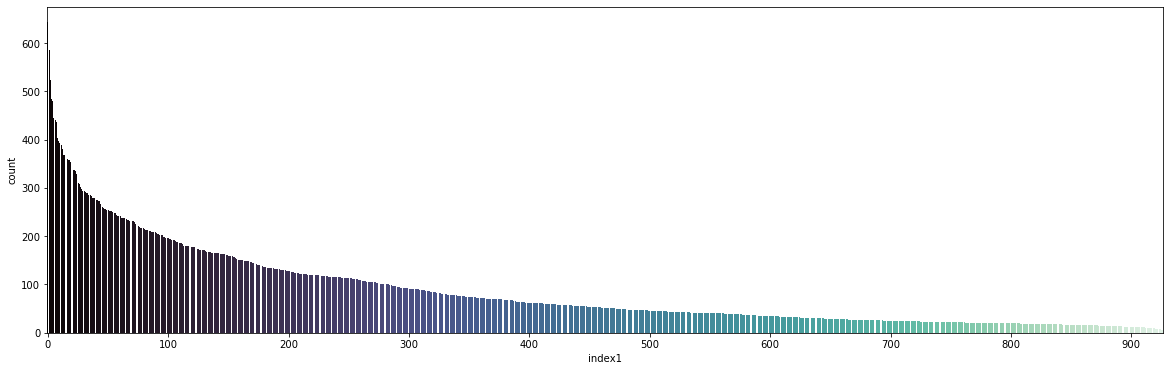

In [138]:
fig, ax1 = plt.subplots(figsize=(20,6))
# sns.lineplot(data = test_df['pres'], sort = False, ax=ax1)
# ax2 = ax1.twinx()
sns.barplot(x="index1", y="count", data=test_df, palette='mako', ax=ax1)
step_xticks = range(0, len(train_count), 100)
_, ax = plt.xticks(step_xticks, step_xticks)

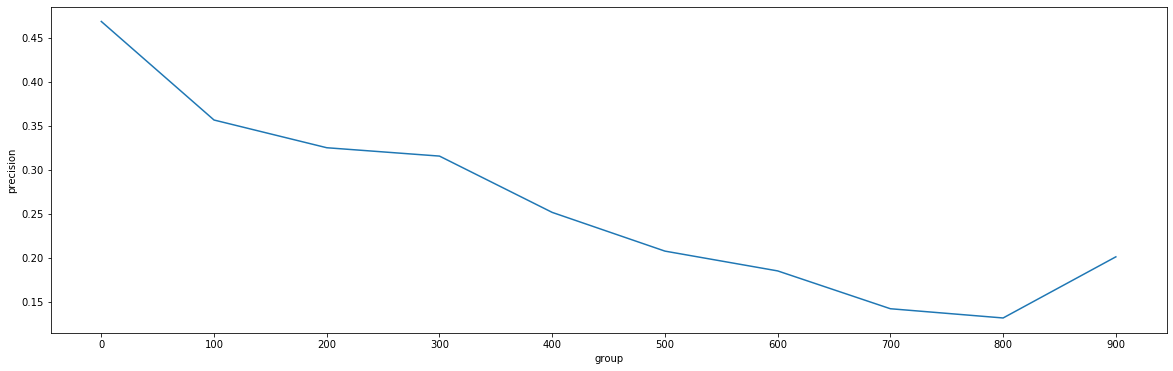

In [ ]:
fig, ax1 = plt.subplots(figsize=(20,6))
m_df = test_df.groupby(['group']).mean()
sns.lineplot(data=m_df['precision'])
_, ax = plt.xticks([i for i in range(len(m_df))], step_xticks)